In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import necessary libraries
import sys, os
import json
import requests
import time
import logging
import datetime as dt
from datetime import date, timedelta, datetime
import dvc.api

from itertools import repeat
import itertools

import numpy as np
import pandas as pd
import statistics as st
import scipy.stats as ss
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns
# To ignore any warnings
import warnings                        
warnings.filterwarnings("ignore")

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

In [3]:
path = 'data/train.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'train_v1'
data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
train_data=pd.read_csv(data_url)
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
path = 'data/test.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'test_v1'
data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
test_data=pd.read_csv(data_url)
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
path = 'data/store.csv'
repo = '/home/bethelhem/Pharmaceutical-Sales-prediction'
version = 'store_v1'
data_url = dvc.api.get_url(
    path = path,
    repo = repo,
    rev=version
    )
store_data=pd.read_csv(data_url)
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


#### Glance the data

In [6]:
print("shape of the  store data: ",store_data.shape)
print(store_data.info())

shape of the  store data:  (1115, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


In [7]:
print("shape of the  train data: ",train_data.shape)
print(train_data.nunique())

shape of the  train data:  (1017209, 9)
Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
dtype: int64


### Data cleaning

In [8]:
#data extraction
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['WeekOfYear'] = train_data['Date'].dt.weekofyear
train_data.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


In [9]:
# impute the missing value in test data
test_data['Open'].fillna(test_data['Open'].mode, inplace = True)
test_data.isnull().values.any()

False

In [10]:
# closed stores
train_data[(train_data.Open == 0) & (train_data.Sales == 0)].count()

Store            172817
DayOfWeek        172817
Date             172817
Sales            172817
Customers        172817
Open             172817
Promo            172817
StateHoliday     172817
SchoolHoliday    172817
Year             172817
Month            172817
Day              172817
WeekOfYear       172817
dtype: int64

In [11]:

print(train_data.shape)
closed_stores = train_data[(train_data['Open'] == 0) & (train_data['Sales'] == 0)].index
train_data.drop(closed_stores,inplace = True)
print(train_data.shape)


(1017209, 13)
(844392, 13)


In [12]:
open_no_sale = train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)].index
train_data[(train_data["Open"] != 0) & (train_data['Sales'] == 0)]['Date'].nunique()

49

In [83]:
# Store with minimum sale count
train_data[train_data["Sales"] == train_data["Sales"].min()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
273387,652,6,2014-11-22,46,8,1,0,0,0,2014,11,22,47


In [82]:
# Store with maximum sale count
train_data[train_data["Sales"] == train_data["Sales"].max()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
44393,909,1,2015-06-22,41551,1721,1,0,0,0,2015,6,22,26


In [13]:
train_data.drop(open_no_sale,inplace = True)
train_data.shape

(844338, 13)

In [14]:


store_exc = train_data[(train_data["StateHoliday"] != "o") 
        & (train_data["Sales"] != 0)]["Store"].nunique()
print("exceptional stores that has opened during state holidays:",store_exc)

exceptional stores that has opened during state holidays: 1115


In [15]:
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [16]:

store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace = True)

In [17]:

store_data['CompetitionOpenSinceMonth'].fillna(store_data['CompetitionOpenSinceMonth'].mode, inplace = True)
store_data['CompetitionOpenSinceYear'].fillna(store_data['CompetitionOpenSinceYear'].mode, inplace = True)
store_data['Promo2SinceWeek'].fillna(store_data['Promo2SinceWeek'].mode, inplace = True)
store_data['Promo2SinceYear'].fillna(store_data['Promo2SinceYear'].mode, inplace = True)
store_data['PromoInterval'].fillna(store_data['PromoInterval'].mode, inplace = True)
store_data.isnull().values.any()

False

In [74]:
print("Joining train set with an additional store information.")
train_store = train_data.merge(store_data,on=["Store"],how="inner")


Joining train set with an additional store information.


In [75]:
train_store.shape

(844338, 22)

In [76]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


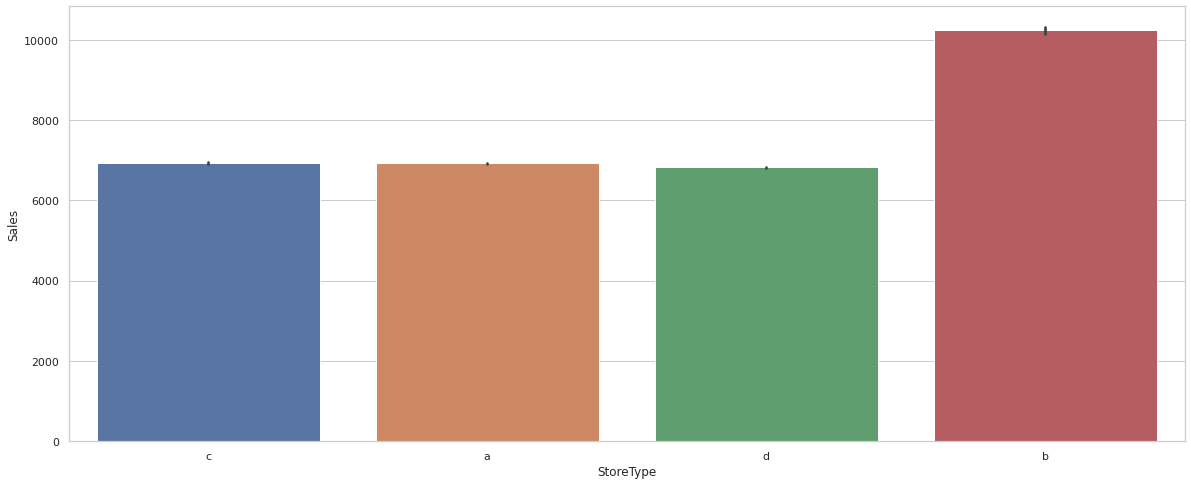

In [91]:
sns.set(style="whitegrid")
ax = sns.barplot(x="StoreType",y="Sales",data=train_store)

In [77]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


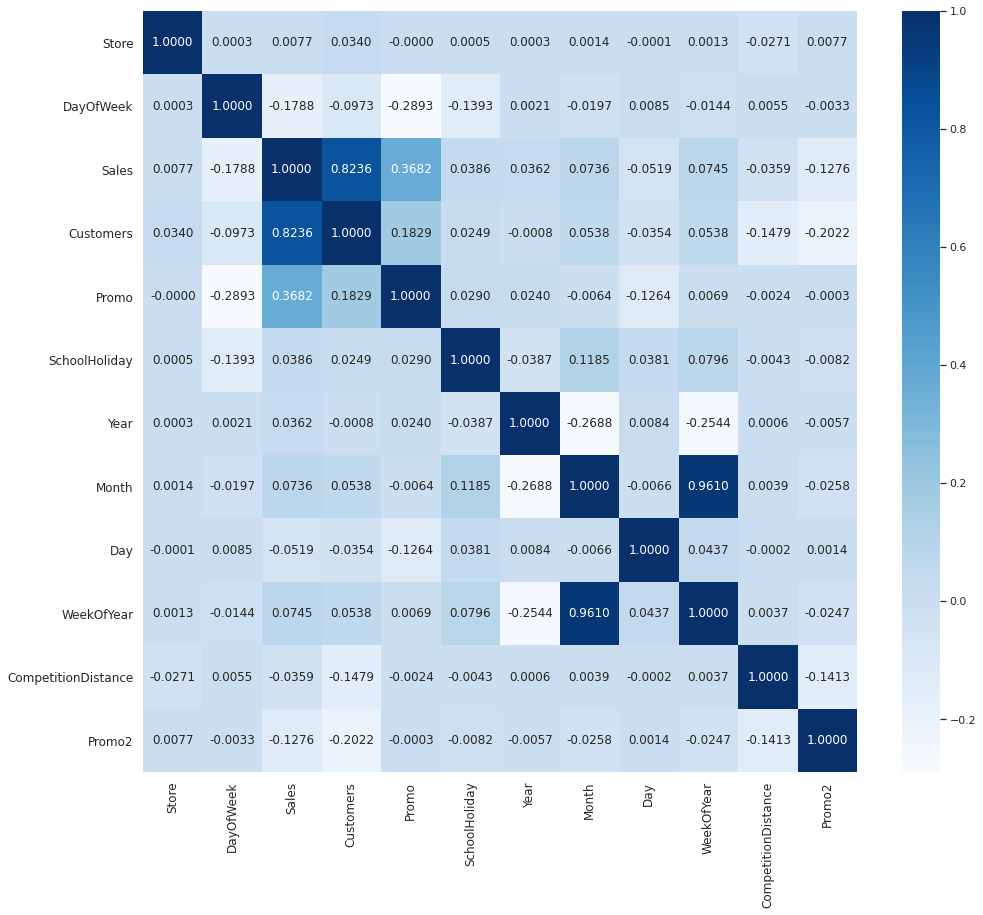

In [78]:
#correlation matrix
corrMatrix= train_store.drop('Open', axis = 1).corr()
f, ax = plt.subplots(figsize=(16, 14))
res=sns.heatmap(corrMatrix,cmap="Blues",annot=True,fmt='.4f',annot_kws={"size":12})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)
plt.show()

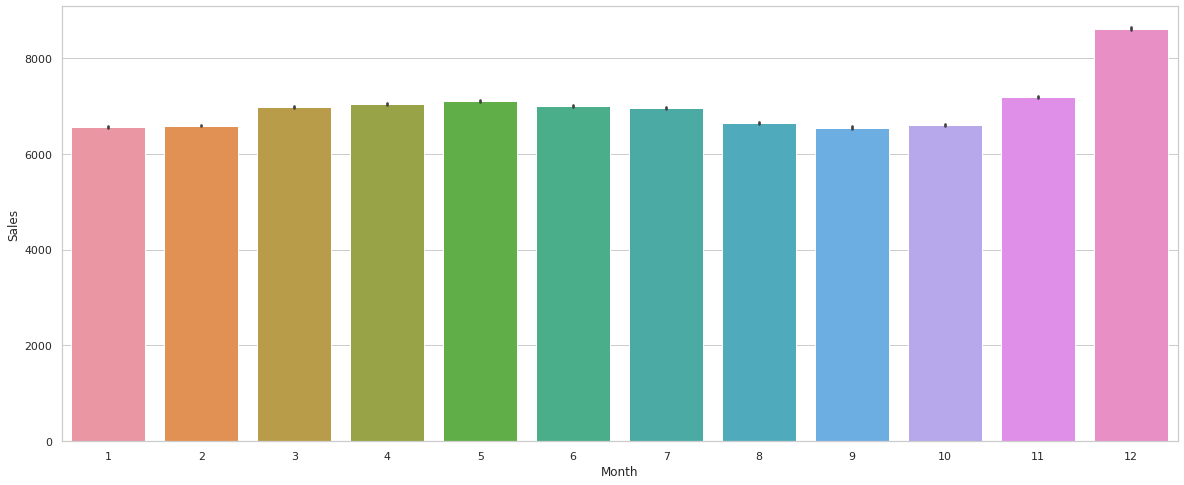

In [90]:
sns.set(style="whitegrid")

ax = sns.barplot(x="Month", y="Sales", data=train_store)

In [23]:
#check seasonality for the given store
def seasonality(store):
    sales = train_data[train_data.Store == store]
    sales = sales.sort_values(by = "Date",ascending= False)
    sns.set(rc = {'figure.figsize':(20,8)})
    sns.lineplot(x = sales["Date"], y = sales["Sales"], color= "green")
    plt.xticks(rotation=90)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Sales', fontsize=16)
    plt.title(f'Seasonality of store {store}\n', size=20, fontweight='bold')
    plt.show()

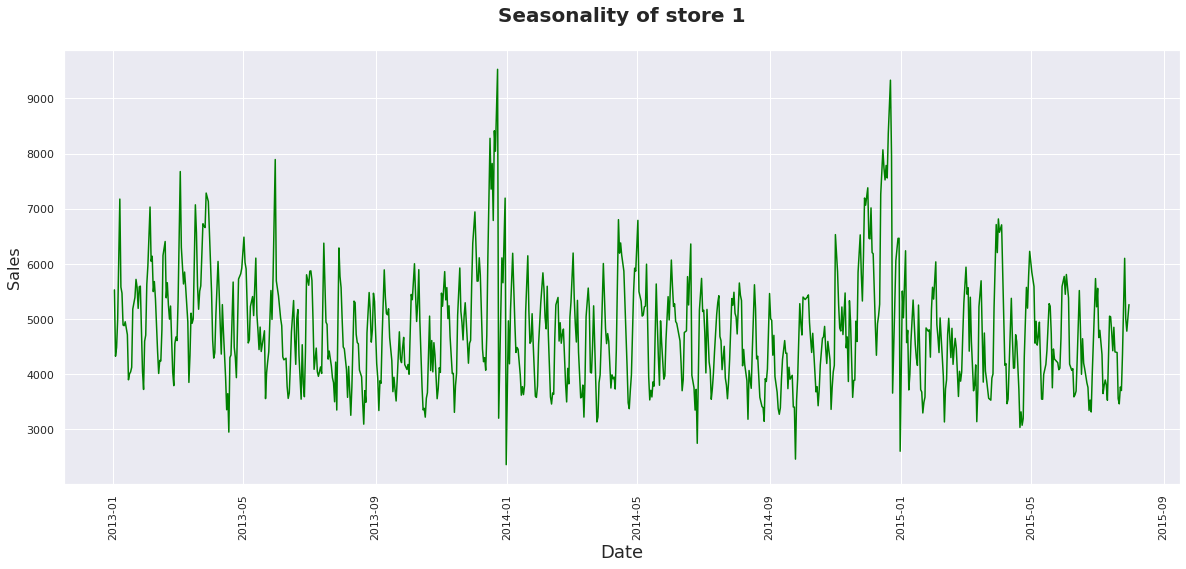

In [24]:
seasonality(1)

In [25]:
#check seasonality for 2013,2014 and 2015 for a given store
def seasonality_year(store):
    sale = train_data[train_data.Store == store]
    sale = sale[(sale.Year == 2015) | (sale.Year == 2014) | (sale.Year == 2013)]
    sale = sale.sort_values(by = "Date",ascending= False)
    sns.set(rc = {'figure.figsize':(20,8)})
    sns.lineplot(x = sale["Date"], y = sale["Sales"], color= "green")
    plt.xticks(rotation=90)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Sales', fontsize=16)
    plt.title(f'Seasonality of store {store} from 2013-2015 \n', size=20, fontweight='bold')
    plt.show()

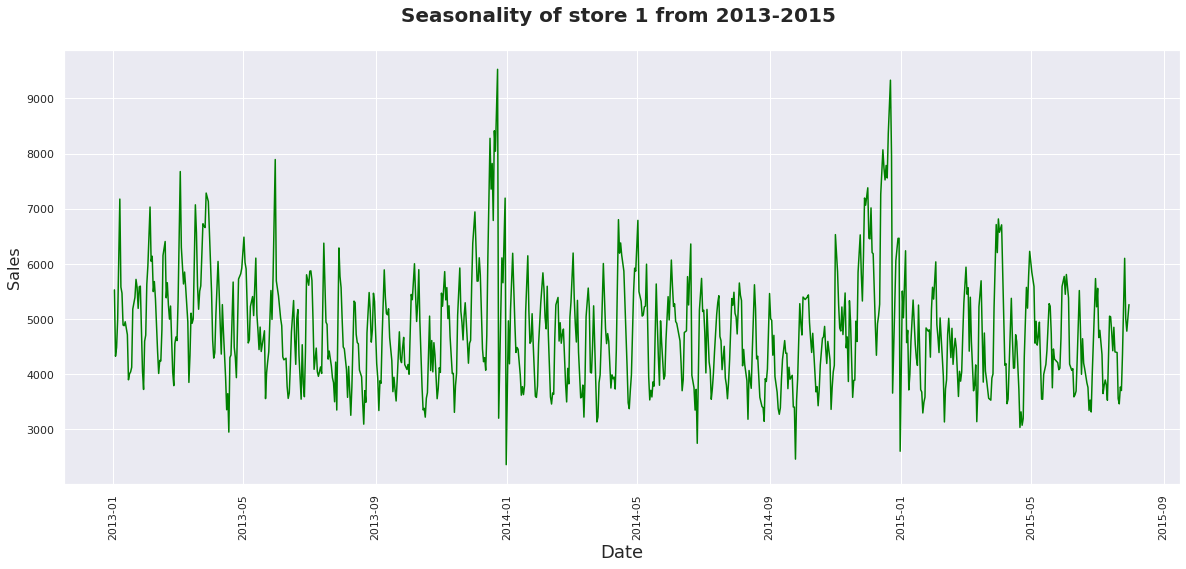

In [26]:
seasonality_year(1)

In [47]:
def plot_counts(df:pd.DataFrame, column1:str) -> None:
    plt.figure(figsize=(4, 2))
    sns.countplot(data=df, x=column1)
    plt.title(f'Distribution of {column1}\n', size=13, fontweight='bold')
    plt.show()

In [55]:
promo = pd.DataFrame()
promo['train promo'] = train_data['Promo']
promo['test promo'] = test_data['Promo']



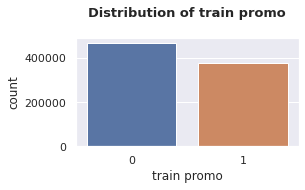

In [56]:

plot_counts(promo, 'train promo')


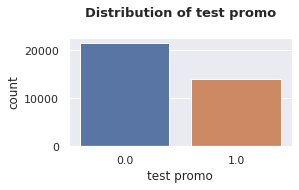

In [57]:

plot_counts(promo, 'test promo')

In [67]:
#sales behavior before, during and after holidays
pre_holiday = train_data[(train_data["Date"]> '2013-12-09') & (train_data["Date"]< '2013-12-22')  ]

during_holiday=train_data[(train_data["Date"]> '2013-12-22') & (train_data["Date"]< '2013-12-31')  ]

post_holiday = train_data[(train_data["Date"]> '2013-12-31') & (train_data["Date"]< '2014-01-15')  ]

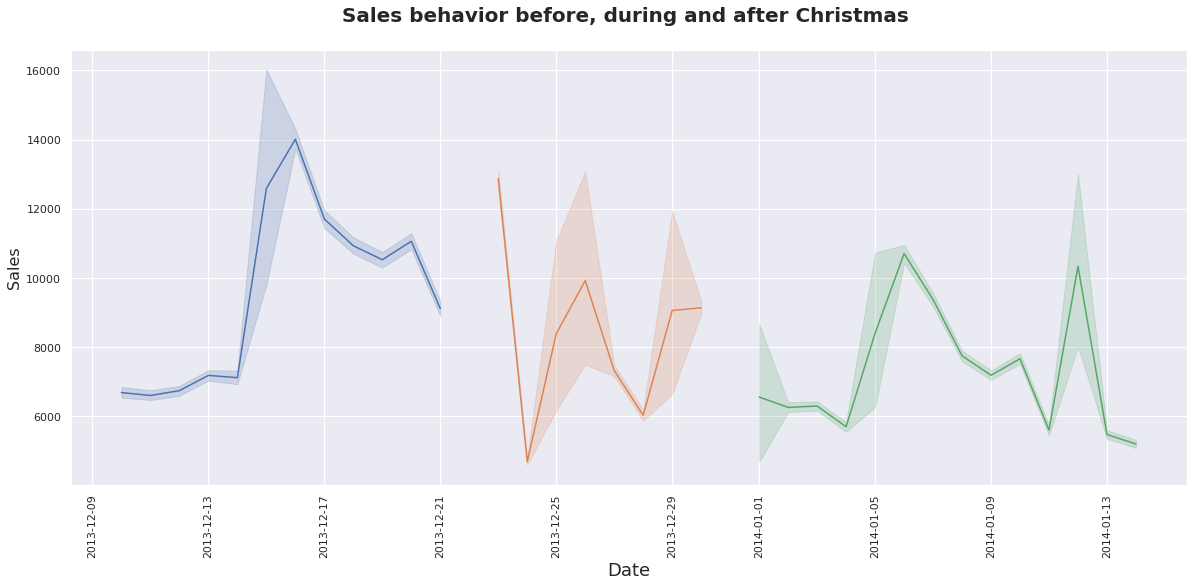

In [68]:
sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Sales"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday["Sales"] )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday["Sales"] )
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.title(f'Sales behavior before, during and after Christmas \n', size=20, fontweight='bold')
plt.show()

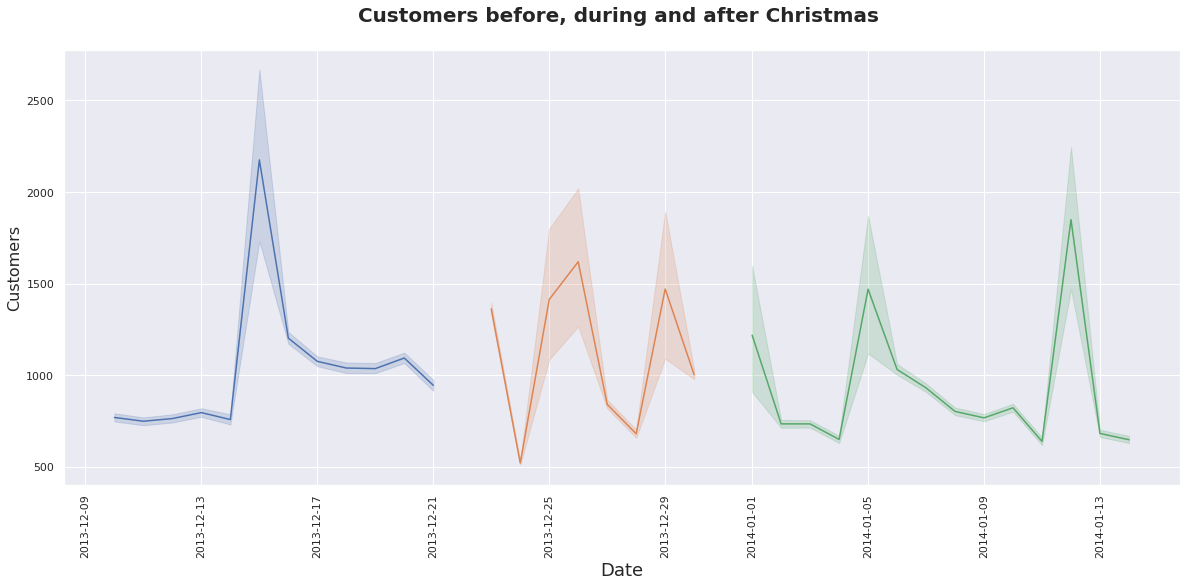

In [69]:

sns.lineplot(x = pre_holiday["Date"] , y = pre_holiday["Customers"] )
sns.lineplot(x = during_holiday["Date"] , y = during_holiday["Customers"] )
sns.lineplot(x = post_holiday["Date"] , y = post_holiday["Customers"] )
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Customers', fontsize=16)
plt.title(f'Customers before, during and after Christmas \n', size=20, fontweight='bold')
plt.show()

In [ ]:
class FetchPrepareData():
    def __init__(self):
        self.dfdict = {}
        self.dfdict['train'] = self.get_train_data()
        self.dfdict['test'] = self.get_test_data()
        self.dfdict['sample'] = self.get_sample_data()
        self.dfdict['store'] = self.get_store_data()
        
    def get_train_data(self,name='train'):
        filename = f'data/{name}.csv'        
        return pd.read_csv(filename)
    
    def get_test_data(self,name='test'):
        filename = f'data/{name}.csv'        
        return pd.read_csv(filename)
        
    def get_store_data(self,name='store'):
        filename = f'data/{name}.csv'        
        return pd.read_csv(filename)  
    
    def get_sample_data(self,name='sample_submission'):
        filename = f'data/{name}.csv'        
        return pd.read_csv(filename)  
        
    def df_to_prophet(self,name='train', 
                timecol="Date",
                targetcol="Sales",
                ftransform=None, 
                prefilter={}, 
                postfilter={},
                rs = '1D'):
        '''
        prepare data frame to prophet modelling
            dfin - input data frame
            timecol - the column name for time/date
            prefilter - a dictionary that contains column_name:value
            postfilter - a dictionary that contains column_name:value
            ftransform - a function to apply after prefiltering takes dfin as input
            rs - unit of time to resample time column 
        '''
        if name in ['train','test','sample']:
            df = self.dfdict[name].copy()
        else:
            print("only name=['train','test','sample'] are allowed")
            return pd.DataFrame()
        
        df['ts'] =  pd.to_datetime(df[timecol]).dt.tz_localize(None)
        df['ts'] = df['ts'].dt.to_pydatetime()

        #apply pre-filter
        for k, v in prefilter.items():
            print(f'Applying pre transform filter with column={k}, value={v}')
            df = df[df[k]==v]

        #transform
        if ftransform is not None:
            print(f'Applying functional transformation ..')
            df = ftransform(df)

        #apply post filter
        for k, v in prefilter.items():
            print(f'Applying post transform filter with column={k}, value={v}')
            df = df[df[k]==v]

        df = df.reset_index().set_index('ts').resample(rs).sum() 
        df = df.reset_index()

        df = df[['ts', targetcol]]
        df = df.rename(columns={"ts": "ds", targetcol: "y"})
        df = df.dropna()
        df.ds = pd.Series([v.to_pydatetime() for v in df.ds], dtype=object)
        return df

def plot_prophet(tsdf, 
                 changepoint_prior_scale=0.001, 
                 seasonality_prior_scale=1.0, 
                 periods=10, 
                 split=0.8 ):
    
    model = (Prophet(changepoint_prior_scale=changepoint_prior_scale, 
                    seasonality_prior_scale=seasonality_prior_scale, 
                    interval_width=0.95, 
                    daily_seasonality=True, 
                    weekly_seasonality=True, 
                    yearly_seasonality=False) \
            .add_seasonality(name='monthly', period=30.5, fourier_order=5) \
            .fit(tsdf)
            )
    
    future = model.make_future_dataframe(periods)
    forecast = model.predict(future)
    components = model.plot_components(forecast)

    forecast.ds = pd.Series([v.to_pydatetime() for v in forecast.ds], dtype=object)

    split = 0.8
    threshold_date_train = tsdf.ds[ int(len(tsdf.ds)*split) ]
    threshold_date_forecast = forecast.ds[ int(len(forecast.ds)*split) ]

    forecast_train = forecast[ threshold_date_forecast >= forecast.ds ]
    forecast_test = forecast[ threshold_date_forecast < forecast.ds ]
    df_train = tsdf[ threshold_date_train >= tsdf.ds ]
    df_test = tsdf[ threshold_date_train < tsdf.ds ]

    fig, ax = plt.subplots(figsize=(20,10))
    sns.set_style('darkgrid', {'axes.facecolor': '.9'})
    sns.set_palette(palette='deep')
    sns_c = sns.color_palette(palette='deep')

    ax.fill_between( x=forecast['ds'], y1=forecast['yhat_lower'], y2=forecast['yhat_upper'],
        color=sns_c[2], alpha=0.25, label=r'0.95 credible_interval')

    sns.scatterplot(x='ds', y='y', label='real historic data', data=df_train, ax=ax, color='black')
    sns.scatterplot(x='ds', y='y', label='real test data', data=df_test, ax=ax, color = 'red')
    sns.lineplot(x='ds', y='yhat', label='historic fit', data=forecast_train, ax=ax, color = 'blue')
    sns.lineplot(x='ds', y='yhat', label='future prediction', data=forecast_test, ax=ax, color = 'orange')
    ax.axvline(threshold_date_train, color=sns_c[3], linestyle='--', label='80% train-test data split')
    ax.legend(loc='upper left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Engagement rate')
    ax.tick_params(axis='x', rotation=45)
    ax.set(title='Engagement rate model fit & prediction for Campaign ID ')
    
    return fig, components
    
    
#     model = Prophet(mcmc_samples=1000).fit(tsdf)
    
#     model = Prophet(seasonality_mode='multiplicative').add_seasonality('quarterly', period=91.25, fourier_order=8, 
#                        mode='additive').add_regressor('regressor', mode='additive').fit(tsdf)
    
#     model = Prophet(seasonality_mode='multiplicative').add_seasonality(name='monthly', period=30.5, fourier_order=5
#             ).add_seasonality(name='weekly', period=7, fourier_order=3
#             ).add_seasonality(name='daily', period=1, fourier_order=1
#             ).fit(tsdf)

In [ ]:
rom.dfdict['train'].head()

In [ ]:
rom = FetchPrepareData()
tsdf = rom.df_to_prophet(name='train',prefilter={'Store':1})
print(tsdf.shape)
tsdf.head()

In [ ]:
plot_prophet(tsdf, changepoint_prior_scale = 10,  periods = 5) 
#              seasonality_prior_scale = 0.05

In [ ]:
model = Prophet(changepoint_prior_scale=0.3, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False).fit(tsdf)
future = model.make_future_dataframe(periods=10)
forecast = model.predict(future)

In [ ]:
df_cv = cross_validation(model, initial='10 days', period = '2 days', horizon = '5 days',) 
#                          parallel="processes")
df_cv

In [ ]:
plot_prophet(tsdf2, changepoint_prior_scale = 10, periods = 1)

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [0.0005, 0.001, 0.005, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.005, 0.01, 0.05, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(tsdf2)  # Fit model with given params
    df_cv = cross_validation(m, horizon= '5 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

In [ ]:
split = 0.8
# el = int(len(tsdf.ds)*split)
threshold_date_train = tsdf.ds[ int(len(tsdf.ds)*split) ]
threshold_date_forecast = forecast.ds[ int(len(forecast.ds)*split) ]

forecast_train = forecast[ threshold_date_forecast >= forecast.ds ]
forecast_test = forecast[ threshold_date_forecast < forecast.ds ]
df_train = tsdf[ threshold_date_train >= tsdf.ds ]
df_test = tsdf[ threshold_date_train < tsdf.ds ]

In [ ]:
plot_prophet(tsdf2, changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.005, periods = 5)

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
# plt.figure()
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

ax.fill_between( x=forecast['ds'], y1=forecast['yhat_lower'], y2=forecast['yhat_upper'],
    color=sns_c[2], alpha=0.25, label=r'0.95 credible_interval')

sns.scatterplot(x='ds', y='y', label='real historic data', data=df_train, ax=ax, color='black')
sns.lineplot(x='ds', y='y', label='model fit', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='historic fit', data=forecast_train, ax=ax, color = 'blue')
sns.lineplot(x='ds', y='yhat', label='future prediction', data=forecast_test, ax=ax, color = 'orange')
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='80% train-test data split')
ax.legend(loc='upper left')
ax.set_xlabel('Date')
ax.set_ylabel('Engagement rate')
ax.tick_params(axis='x', rotation=45)
ax.set(title='Engagement rate model fit & prediction for Campaign ID ')